In [1]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Evaluate Realism and Diversity of the generated images

This notebook illustrates how to use the generative model package to compute the most common metrics to evaluate the performance of a generative model. The metrics that we will analyse on this tutorial are:

- Frechet Inception Distance (FID) [1] and Maximum Mean Discrepancy (MMD) [2], two metrics commonly used to assess the realism of generated image

- the MS-SSIM [3] and SSIM [4] used to evaluate the image diversity

Note: We are using the RadImageNet [5] to compute the feature space necessary to compute the FID. So we need to transfom the images in the same way they were transformed when the network was trained before computing the FID.

[1] - Heusel et al., "Gans trained by a two time-scale update rule converge to a local nash equilibrium", https://arxiv.org/pdf/1706.08500.pdf

[2] - Gretton et al., "A Kernel Two-Sample Test", https://www.jmlr.org/papers/volume13/gretton12a/gretton12a.pdf

[3] - Wang et al., "Multiscale structural similarity for image quality assessment", https://ieeexplore.ieee.org/document/1292216

[4] - Wang et al., "Image quality assessment: from error visibility to structural similarity", https://ieeexplore.ieee.org/document/1284395

[5] - Mei et al., "RadImageNet: An Open Radiologic Deep Learning Research Dataset for Effective Transfer Learning, https://pubs.rsna.org/doi/10.1148/ryai.210315

## Setup environment

In [3]:
import torch
import os
import torch
from pathlib import Path

import matplotlib.pyplot as plt
from monai.apps import MedNISTDataset
from monai import transforms
from monai.data import DataLoader, Dataset
from monai.networks.layers import Act


from monai.config import print_config
from monai.utils import set_determinism

from generative.metrics import FIDMetric, MMDMetric, MultiScaleSSIMMetric, SSIMMetric
from generative.networks.nets import DiffusionModelUNet, PatchDiscriminator, AutoencoderKL
from generative.networks.schedulers import DDIMScheduler
from generative.inferers import DiffusionInferer

print_config()

 missing cuda symbols while dynamic loading
 cuFile initialization failed
MONAI version: 1.2.dev2304
Numpy version: 1.23.4
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9a57be5aab9f2c2a134768c0c146399150e247a0
MONAI __file__: /home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.11.2
gdown version: 4.6.0
TorchVision version: 0.14.0
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



The transformations defined below are necessary in order to transform the input images in the same way that the images were
processed for the RadNet train.

In [4]:
def subtract_mean(x: torch.Tensor) -> torch.Tensor:
    mean = [0.406, 0.456, 0.485]
    x[:, 0, :, :] -= mean[0]
    x[:, 1, :, :] -= mean[1]
    x[:, 2, :, :] -= mean[2]
    return x

def normalize_tensor(x: torch.Tensor, eps: float=1e-10) -> torch.Tensor:
    norm_factor = torch.sqrt(torch.sum(x**2, dim=1, keepdim=True))
    return x / (norm_factor + eps)

def spatial_average(x: torch.Tensor, keepdim: bool=True) -> torch.Tensor:
    return x.mean([2, 3], keepdim=keepdim)

def get_features(image):

    # If input has just 1 channel, repeat channel to have 3 channels
    if image.shape[1]:
        image = image.repeat(1, 3, 1, 1)

    # Change order from 'RGB' to 'BGR'
    image = image[:, [2, 1, 0], ...]

    # Subtract mean used during training
    image = subtract_mean(image)

    # Get model outputs
    with torch.no_grad():
        feature_image = radnet.forward(image)
        # flattens the image spatially
        feature_image = spatial_average(feature_image, keepdim=False)

    return feature_image

## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.
This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpzmzorzlg


## Set deterministic training for reproducibility

In [6]:
set_determinism(5)

## Define the models

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [8]:
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    latent_channels=3,
    num_channels=[64, 128, 128],
    num_res_blocks=1,
    norm_num_groups=32,
    attention_levels=(False, False, True),
)
autoencoderkl = autoencoderkl.to(device)

In [9]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_res_blocks=(1, 1, 1),
    num_channels=(64, 128, 128),
    attention_levels=(False, True, True),
    num_head_channels=128
)

scheduler = DDIMScheduler(num_train_timesteps=1000, beta_schedule="linear", beta_start=0.0015, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)

discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    num_channels=32,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device)
unet = unet.to(device)

## Load pre-trained model

Here we will use a pre-trained version of the DDPM downloaded from torch. However, users can also use a local model and evaluate its metrics if they want.

In [10]:
use_pre_trained = True

In [11]:
if use_pre_trained:
    unet = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True)
    unet = unet.to(device)
else:
    model_path = Path.cwd() / Path("tutorials/generative/2d_ldm/best_aeutoencoderkl.pth")
    autoencoderkl.load_state_dict(torch.load(str(model_path)))
    model_path = Path.cwd() / Path("tutorials/generative/2d_ldm/best_unet.pth")
    unet.load_state_dict(torch.load(str(model_path)))

Using cache found in /home/jdafflon/.cache/torch/hub/marksgraham_pretrained_generative_models_v0.2


## Get the real images

Simialry to the 2D LDM tutorial here we will use the MedNISTDataset, which contains images from different body parts. For easiness, here we will use only the `Hand` class. The first part of the code will get the real images from the MedNISTDataset and apply some transformation to scale the intensity of the image. Because we are evaluating the performance of the trained network, we will only use the validation split.

In [12]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=180, shuffle=True, num_workers=4)

2023-05-02 01:39:22,365 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-05-02 01:39:22,365 - INFO - File exists: /tmp/tmpzmzorzlg/MedNIST.tar.gz, skipped downloading.
2023-05-02 01:39:22,366 - INFO - Non-empty folder exists in /tmp/tmpzmzorzlg/MedNIST, skipped extracting.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5895/5895 [00:02<00:00, 2474.62it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.53it/s]


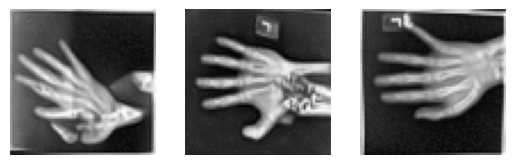

In [13]:
# Create some synthetic data for visualisation
n_synthetic_images = 3
noise = torch.randn((n_synthetic_images, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=50)
unet.eval()

with torch.no_grad():
    syn_images, intermediates = inferer.sample(input_noise=noise, diffusion_model=unet,
                                              scheduler=scheduler,save_intermediates=True,
                                              intermediate_steps=100)

# Plot 3 examples from the synthetic data
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(syn_images[image_n, 0, :, :].cpu(), cmap="gray")
    ax[image_n].axis("off")

## Compute FID

The FID measures the distance between the feature vectors from the real images and those obtained from generated images. In order to compute the FID the images need to be passed into a pre-trained network to get the desired feature vectors. Although the FID is commonly computed using the Inception network, here, we used a pre-trained version of the RadImageNet to calculate the feature space. Lower FID scores indicate that the images are more similar, with a perfect score being 0 indicating that the two groups of images are identical.

In [14]:
radnet = torch.hub.load("Warvito/radimagenet-models", model="radimagenet_resnet50", verbose=True)
radnet.to(device)
radnet.eval()

Using cache found in /home/jdafflon/.cache/torch/hub/Warvito_radimagenet-models_main


ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1.001e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm

Here, we will load the real and generate synthetic images from noise and compute the FID of these two groups of images. Because we are generating the synthetic images on this code snippet the entire cell will take about 6 mins run and most of the this time is spent in generating the images. The loading bars show how long it will take to complete the image generation for each mini-batch.

In [15]:
fid_scores = []
unet.eval()

for step, x in enumerate(val_loader):
    # Get the real images
    real_images = x["image"].to(device)

    # Generate some synthetic images using the defined model
    n_synthetic_images = len(x['image'])
    noise = torch.randn((n_synthetic_images, 1, 64, 64))
    noise = noise.to(device)
    scheduler.set_timesteps(num_inference_steps=25)

    with torch.no_grad():
        syn_images, intermediates = inferer.sample(input_noise=noise, diffusion_model=unet,
                                                  scheduler=scheduler,save_intermediates=True,
                                                  intermediate_steps=100)

        # Get the features for the real data
        real_eval_feats = get_features(real_images)

        # Get the features for the synthetic data
        synth_eval_feats = get_features(syn_images)

        fid = FIDMetric()
        fid_res = fid(synth_eval_feats.to(device), real_eval_feats.to(device))
        fid_scores.append(fid_res)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.86it/s]


In [16]:
fid_scores = torch.stack(fid_scores)
print(f"FID Score: {fid_scores.mean().item():.4f} +- {fid_scores.std().item():.4f}")

FID Score: 18.1120 +- 1.8559


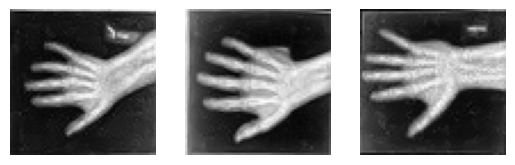

In [17]:
# Plot 3 examples from the synthetic data
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(syn_images[image_n, 0, :, :].cpu(), cmap="gray")
    ax[image_n].axis("off")

# Compute MMD

MMD (Maximum Mean Discrepancy) is a distance metric used to measure the similarity between two probability distributions. This metric maps the samples from each distribution to a high-dimensional feature space and calculates the distance between the mean of the features of each distribution. A smaller MMD value indicates a better match between the real and generated distributions. It is often used in combination with other evaluation metrics to assess the performance of a generative model.

In [18]:
mmd_scores = []
autoencoderkl.eval()

mmd = MMDMetric()

for step, x in list(enumerate(val_loader)):
    image = x["image"].to(device)

    with torch.no_grad():
        image_recon = autoencoderkl.reconstruct(image)

    mmd_scores.append(mmd(image, image_recon))

mmd_scores = torch.stack(mmd_scores)
print(f"MS-SSIM score: {mmd_scores.mean().item():.4f} +- {mmd_scores.std().item():.4f}")


MS-SSIM score: 0.8309 +- 0.0127


# Compute MultiScaleSSIMMetric and SSIMMetric

Both MS-SSIM and SSIM can be used as metric to evaluate the diversity.

SSIM measures the similarity between two images based on three components: luminance, contrast, and structure. In addition, MS-SSIM is an extension of SSIM that computes the structural similarity measure at multiple scales. Both metrics can assume values between 0 and 1, where 1 indicates perfect similarity between the images.

In this section we will compute the MS-SSIM and SSIM Meteric between the real images and those reconstructed by the AutoencoderKL.

In [19]:
ms_ssim_recon_scores = []
ssim_recon_scores = []
autoencoderkl.eval()

ms_ssim = MultiScaleSSIMMetric(spatial_dims=2, data_range=1.0, kernel_size=4)
ssim = SSIMMetric(spatial_dims=2, data_range=1.0, kernel_size=4)

for step, x in list(enumerate(val_loader)):
    image = x["image"].to(device)

    with torch.no_grad():
        image_recon = autoencoderkl.reconstruct(image)

    ms_ssim_recon_scores.append(ms_ssim(image, image_recon))
    ssim_recon_scores.append(ssim(image, image_recon))

ms_ssim_recon_scores = torch.cat(ms_ssim_recon_scores, dim=0)
ssim_recon_scores = torch.cat(ssim_recon_scores, dim=0)

print(f"MS-SSIM Metric: {ms_ssim_recon_scores.mean():.7f} +- {ms_ssim_recon_scores.std():.7f}")
print(f"SSIM Metric: {ssim_recon_scores.mean():.7f} +- {ssim_recon_scores.std():.7f}")


MS-SSIM Metric: 0.0017757 +- 0.0110144
SSIM Metric: -0.0090123 +- 0.0118101


Compute the SSIM and MS-SSIM between synthetic and real images. Note that here we are regenerating some synthetic images.

In [20]:
ms_ssim_scores = []
ssim_scores = []
unet.eval()

for step, x in enumerate(val_loader):
    # Get the real images
    real_images = x["image"].to(device)

    # Generate some synthetic images using the defined model
    n_synthetic_images = len(x['image'])
    noise = torch.randn((n_synthetic_images, 1, 64, 64))
    noise = noise.to(device)
    scheduler.set_timesteps(num_inference_steps=25)

    with torch.no_grad():
        syn_images, intermediates = inferer.sample(input_noise=noise, diffusion_model=unet,
                                                  scheduler=scheduler,save_intermediates=True,
                                                  intermediate_steps=100)

        ms_ssim_scores.append(ms_ssim(real_images, syn_images))
        ssim_scores.append(ssim(real_images, syn_images))

ms_ssim_scores = torch.cat(ms_ssim_scores, dim=0)
ssim_scores = torch.cat(ssim_scores, dim=0)

print(f"MS-SSIM Metric: {ms_ssim_scores.mean():.7f} +- {ms_ssim_scores.std():.7f}")
print(f"SSIM Metric: {ssim_scores.mean():.7f} +- {ssim_scores.std():.7f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.85it/s]


MS-SSIM Metric: 0.3694367 +- 0.1433250
SSIM Metric: 0.1711924 +- 0.0788519
